*Los modelos predictivos en el ámbito del machine learning representan una herramienta invaluable para el análisis y la mejora continua de las operaciones empresariales. En particular, en este proyecto centrado en el sector de las tarjetas de crédito, se explorará la aplicación de técnicas predictivas para evaluar la probabilidad de abandono de clientes del banco. A través de la identificación de patrones significativos en los datos, se buscará comprender mejor el comportamiento de los clientes y anticipar posibles acciones de abandono. Posteriormente, se implementarán medidas estratégicas con el fin de mitigar estos riesgos y fomentar la retención de clientes. Este enfoque no solo busca optimizar la rentabilidad del negocio, sino también fortalecer la relación con los clientes al ofrecer soluciones personalizadas y proactivas.*

- *Medida elegida: *La precisión* en problemas de clasificación indica qué tan exacto es un modelo en predecir la clase correcta. Optimizarla nos ayudará a mejorar la confiabilidad de nuestras predicciones, lo que es crucial para la seguridad financiera y la satisfacción del cliente.*

*La precisión en este caso sería la medida de cuántos de los clientes que el modelo predice que van a abandonar realmente lo hacen. Por ejemplo, si el modelo predice que 100 clientes abandonarán el banco y 85 de ellos realmente lo hacen, la precisión sería del 85%. Una alta precisión aquí significa que el banco puede identificar con confianza a la mayoría de los clientes propensos a abandonarlo, permitiéndoles tomar medidas proactivas para retenerlos y optimizar recursos.*

<div style="text-align:center;">
    <img src="img\precision.jpg" alt="Texto alternativo" width=500px >
</div>

### **Librerías**

In [1]:
### Manipulación de Datos
import pandas as pd
import numpy as np

### Visualización de Datos
import seaborn as sns
import matplotlib.pyplot as plt

### Tratamiento de datos
from utils.funciones import extended_describe

### Machine Learning
# Preparación de datos 
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  RandomForestClassifier,  GradientBoostingClassifier, VotingClassifier,  AdaBoostClassifier, StackingClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import  classification_report, confusion_matrix,  accuracy_score, f1_score,  precision_score, recall_score, \
roc_curve, roc_auc_score, ConfusionMatrixDisplay, multilabel_confusion_matrix, make_scorer


from sklearn.model_selection import GridSearchCV
import pickle
from utils.funciones import BaseLine

# Ignorar warnings
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv('./data/processed/Churn_Modelling.csv')

### **Modelo 1**
**Sin feature enginering y con OneHotEncoder**


Antes de iniciar cualquier análisis de datos, es crucial comprender la estructura y la naturaleza de los datos en su forma original. Esto proporciona una base sólida para evitar errores comunes, como el sobreajuste y la mala interpretación de los resultados. Es esencial establecer una referencia clara de cómo se reciben los datos inicialmente, ya que cualquier manipulación posterior podría influir en los resultados finales.

In [2]:
df = pd.read_csv('./data/processed/Churn_Modelling.csv')
df.drop(columns=['RowNumber', 'CustomerId', 'Surname',], inplace=True)

# Definir las variables X e y
X = df.drop(columns=['Exited'])
y = df['Exited']

numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
variables_sin_modificacion = ['HasCrCard', 'IsActiveMember']
categorical_features = ['Geography', 'Gender']

# Definir transformadores para características numéricas y categóricas
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

# Crear un ColumnTransformer para aplicar transformaciones a diferentes columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Crear el pipeline con el preprocesador
pipeline = make_pipeline(preprocessor)
# Aplicar el preprocesador a los datos
X_processed = pipeline.fit_transform(X)

# Obtener los nombres de las columnas después de aplicar OneHotEncoder
encoded_categorical_columns = preprocessor.named_transformers_['cat']\
    .get_feature_names_out(input_features=categorical_features)

# Combinar los nombres de las columnas numéricas y categóricas
processed_columns = numeric_features + list(encoded_categorical_columns)

# Crear DataFrame con los datos procesados y los nombres de las columnas
processed_df = pd.DataFrame(X_processed, columns=processed_columns)
concatenated_series  = pd.concat((processed_df, X[[ 'HasCrCard', 'IsActiveMember']]), axis=1)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(concatenated_series, y, test_size=0.2, random_state=24)

# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=24)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

BaseLine(X_train_resampled, y_train_resampled, cv=5, metricas_cross_validate= ['accuracy', 'f1_macro', 'recall_macro', 'precision_macro']) # Realizar un baseline -> input = todos


La mayoría de nuestros datos se ajustan adecuadamente según la media obtenida mediante la validación cruzada. Esta técnica implica dividir el conjunto de datos en múltiples subconjuntos, alternando entre ellos para entrenar y evaluar el modelo. La media de las métricas de rendimiento proporciona una evaluación más robusta del modelo, ya que no depende de una sola división de los datos. Es importante recordar que los valores en el conjunto de datos son aproximados y redondeados, lo que facilita la aplicación de modelos y la selección de los más adecuados.

La validación cruzada es esencial para evaluar la capacidad de generalización de un modelo. Consiste en dividir el conjunto de datos en k subconjuntos (llamados "folds"), donde uno de los subconjuntos se reserva como conjunto de prueba y los restantes se utilizan como conjunto de entrenamiento. Este proceso se repite k veces, de manera que cada subconjunto se utilice como conjunto de prueba exactamente una vez. Finalmente, se promedian los resultados de evaluación para obtener una estimación más precisa del rendimiento del modelo en datos no vistos. Esto ayuda a evitar el sobreajuste al evaluar el modelo en diferentes conjuntos de datos y garantiza una evaluación más robusta de su capacidad de generalización.

<div style="text-align:center;">
    <img src="img\cross_validate_explicacion.png" alt="Texto alternativo" width=500px >
</div>


|Métricas | Valores |
|------|-------|
|Random Forest_accuracy|	0.905824|
|Random Forest_f1_macro|	0.905501|
|Random Forest_recall_macro|	0.905816|
|Random Forest_precision_macro|	0.909381|

<br>

|Métricas | Valores |
|--------|--------|
|XGBoost_recall|	0.885894|
|XGBoost_precision|	0.902164|
|XGBoost_f1| 0.882241|
|XGBoost_accuracy|	0.885912|

In [3]:
# grid_1 = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [20, 30, None],
#     'min_samples_split': [2, 10],
#     'min_samples_leaf': [1, 5, 10],
#     'max_features': ['auto', 'sqrt'],
#     'bootstrap': [True, False]
# }

# forest = RandomForestClassifier()

# grd_search_forest = GridSearchCV(forest,
#                            grid_1,
#                            cv=5,
#                            scoring='precision_macro',
#                            n_jobs=-1
#                           )

# grd_search_forest.fit(X_train_resampled, y_train_resampled)

# print('Los mejores hiperparámetros obtenidos:', grd_search_forest.best_params_)
# print(classification_report(y_test, grd_search_forest.predict(X_test)))

# # Guardar el modelo en un archivo
# with open('modelo_forest_1.pkl', 'wb') as f:
#     pickle.dump(grd_search_forest, f)

# # Cargar el modelo desde el archivo
with open('./modelos/modelo_forest_1.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
    
print(classification_report(y_test, loaded_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1587
           1       0.66      0.55      0.60       413

    accuracy                           0.85      2000
   macro avg       0.78      0.74      0.75      2000
weighted avg       0.84      0.85      0.84      2000



 Los mejores hiperparámetros del randomForest fueron : *{'bootstrap': **False**, 'max_depth': **30**, 'max_features': **'sqrt'**, 'min_samples_leaf': **1**, 'min_samples_split': **2**, 'n_estimators': **200**}*
 
Los resultados de la validación cruzada revelaron una disminución en las métricas, lo cual podría atribuirse al sobreajuste inherente del algoritmo de Random Forest si no se realiza un adecuado proceso de poda. Sin embargo, a pesar de este desafío, nuestras métricas actuales no son desalentadoras. Es evidente que existe margen para mejorar especialmente la precisión en las características del uno, que actualmente se sitúa en un 66%. Nuestro objetivo es alcanzar un nivel de precisión del 90% o incluso del 94%, lo que nos impulsará hacia una mayor confiabilidad en las predicciones y una toma de decisiones más efectiva. En resumen, el enfoque se centrará en implementar estrategias de poda adecuadas para mitigar el sobreajuste y en afinar aún más el modelo para alcanzar nuestras metas de precisión.

Hemos adoptado una estrategia de almacenamiento de modelos para evitar el sobreprocesamiento. Así optimizamos nuestros recursos y garantizamos una selección eficiente del modelo más adecuado.

In [4]:
# grid_2 = {
#     'n_estimators': [100, 150, 200],
#     'learning_rate': [0.01, 0.05],
#     'max_depth': [4, 6, 8],
#     'subsample': [0.7, 0.9],
#     'colsample_bytree': [0.7, 0.9]
# }


# xgbBoost = xgb.XGBClassifier()

# grd_search_xgbBoost = GridSearchCV(xgbBoost,
#                            grid_2,
#                            cv=5,
#                            scoring='precision_macro',
#                            n_jobs=-1
#                           )

# grd_search_xgbBoost.fit(X_train_resampled, y_train_resampled)

# # Guardar el modelo en un archivo
# with open('./modelos/modelo_xgbCla_1.pkl', 'wb') as f:
#     pickle.dump(grd_search_xgbBoost, f)
    
# # # Cargar el modelo desde el archivo
with open('./modelos/modelo_xgbCla_1.pkl', 'rb') as f:
    loaded_model_xgb = pickle.load(f)
    
print(classification_report(y_test, loaded_model_xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1587
           1       0.69      0.57      0.62       413

    accuracy                           0.86      2000
   macro avg       0.79      0.75      0.77      2000
weighted avg       0.85      0.86      0.85      2000



Los mejores hiperparámetros del XGBClassifier fueron : *{'colsample_bytree': **0.7**, 'learning_rate': **0.05**, 'max_depth': **8**, 'n_estimators':**200**, 'subsample': **0.7**}*

Las métricas mejoraron al emplear el XGBoost Classifier en comparación con el Random Forest. Esta mejora indica la eficacia del XGBoost en nuestro conjunto de datos y resalta su capacidad para generar modelos más precisos.

### **Modelo 2**
**Con feature enginering y OneHotEncoder**

In [7]:
df = pd.read_csv('./data/processed/Churn_Modelling.csv')
# Este ratio te daría una medida de la proporción del saldo en la cuenta en relación con el salario estimado anual del cliente. 
# Calcular el ratio entre el saldo en la cuenta y el salario estimado anual
df['Saldo_Salario_Ratio'] = df['Balance'] / df['EstimatedSalary']
# Agregar una pequeña cantidad a la antigüedad para evitar la división por cero
df['Balance_Tenure_Ratio'] = df['Balance'] / (df['Tenure'] + 1e-6)

# Definir las variables X e y
X = df.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Exited', 'Tenure', 'Balance']) # Evitamos la colinealidad
y = df['Exited']

numeric_features = ['CreditScore', 'Age', 'NumOfProducts',  'EstimatedSalary', 'Saldo_Salario_Ratio', 'Balance_Tenure_Ratio']
categorical_features = ['Geography', 'Gender']

# Definir transformadores para características numéricas y categóricas
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

# Crear un ColumnTransformer para aplicar transformaciones a diferentes columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Crear el pipeline con el preprocesador
pipeline = make_pipeline(preprocessor)

X_processed = pipeline.fit_transform(X)

# Obtener los nombres de las columnas después de aplicar OneHotEncoder
encoded_categorical_columns = preprocessor.named_transformers_['cat']\
    .get_feature_names_out(input_features=categorical_features)

# Combinar los nombres de las columnas numéricas y categóricas
processed_columns = numeric_features + list(encoded_categorical_columns)

# Crear DataFrame con los datos procesados y los nombres de las columnas
processed_df = pd.DataFrame(X_processed, columns=processed_columns)
concatenated_series  = pd.concat((processed_df, X[[ 'HasCrCard', 'IsActiveMember']]), axis=1)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(concatenated_series, y, test_size=0.2, random_state=24)

# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=24)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

BaseLine(X_train_resampled, y_train_resampled, cv=5, metricas_cross_validate= ['accuracy', 'f1_macro', 'recall_macro', 'precision_macro']) # Realizar BaseLine -> input = todos

Hemos observado que la inclusión de nuevas características no produjo los resultados esperados en la mejora de nuestros modelos. Esta constatación resalta la importancia de la selección cuidadosa de características en el proceso de modelado. En lugar de simplemente agregar más variables, debemos enfocarnos en identificar aquellas que aporten un valor significativo y contribuyan de manera efectiva a la precisión del modelo. 

<br>

|Métricas | Valores |
|--------|--------|
|Random Forest_recall|	0.885585|
|Random Forest_precision|	0.887898|
|Random Forest_f1|	0.885408|
|Random Forest_accuracy|	0.885590|

<br>

|Métricas | Valores |
|--------|--------|
|CatBoost_recall|	0.880327|
|CatBoost_precision|	0.894255|
|CatBoost_f1|	0.876986|
|CatBoost_accuracy|	0.880344|


In [8]:
# grid_3 = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [10, 20, None],
#     'min_samples_split': [2, 10],
#     'max_features': ['auto', 'sqrt'],
#     'bootstrap': [True, False]
# }

# forest_conFeature = RandomForestClassifier()

# grd_search_forest_conFeature = GridSearchCV(forest_conFeature,
#                            grid_3,
#                            cv=5,
#                            scoring='precision_macro',
#                            n_jobs=-1
#                           )

# grd_search_forest_conFeature.fit(X_train_resampled, y_train_resampled)

# grd_search_forest_conFeature.best_params_
# print(classification_report(y_test, grd_search_forest_conFeature.predict(X_test)))

# # Guardar el modelo en un archivo
# with open('./modelos/modelo_forest_Confeature_1.pkl', 'wb') as f:
#     pickle.dump(grd_search_forest_conFeature, f)
    
# # # Cargar el modelo desde el archivo
with open('./modelos/modelo_forest_Confeature_1.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
    
print(classification_report(y_test, loaded_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89      1587
           1       0.59      0.58      0.58       413

    accuracy                           0.83      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.83      0.83      0.83      2000



Los mejores hiperparametros son : *{'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}*



*************

### **Modelo 3 - CatBoost**
**Con feature enginering**

El CatBoost es un conjunto de árboles de decisión que destaca por su capacidad para manejar variables categóricas sin necesidad de preprocesamiento adicional. A diferencia de la mayoría de los modelos, que requieren la conversión de variables categóricas a numéricas, el CatBoost puede trabajar directamente con ellas, lo que simplifica significativamente el proceso de modelado. En el caso de nuestro baseline, hemos observado que el CatBoost proporciona resultados satisfactorios incluso cuando se utiliza con variables numéricas, lo que nos motiva a explorar su desempeño sin necesidad de procesar las características previamente. Esta decisión nos permitirá aprovechar al máximo las capacidades inherentes del CatBoost y potencialmente mejorar la eficacia de nuestro modelo.

In [10]:
df = pd.read_csv('./data/processed/Churn_Modelling.csv')

df['CreditCardOwnerTenure'] = df.HasCrCard * df.Age
# Calcular el ratio entre el saldo en la cuenta y el salario estimado anual
df['Saldo_Salario_Ratio'] = df['Balance'] / df['EstimatedSalary']

# Definir las variables X e y
X = df.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Exited']) # Evitamos la colinealidad
y = df['Exited']

numeric_features = ['CreditScore', 'Age', 'NumOfProducts',  'EstimatedSalary', 'Saldo_Salario_Ratio',  'Tenure', 'Balance', 'CreditCardOwnerTenure']
categorical_features = ['Geography', 'Gender']

# Definir transformadores para características numéricas y categóricas
numeric_transformer = StandardScaler()

# Crear un ColumnTransformer para aplicar transformaciones a diferentes columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ]
)

# Crear el pipeline con el preprocesador
pipeline = make_pipeline(preprocessor)

X_processed = pipeline.fit_transform(X)

# Crear DataFrame con los datos procesados y los nombres de las columnas
processed_df = pd.DataFrame(X_processed, columns=numeric_features)
concatenated_series  = pd.concat((processed_df, X[[ 'HasCrCard', 'IsActiveMember', 'Geography', 'Gender']]), axis=1)
concatenated_series

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(concatenated_series, y, test_size=0.2, random_state=24)

# # Aplicar SMOTE solo al conjunto de entrenamiento
# smote = SMOTE(random_state=24)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) # el smote no acepta categoricos por ende el catboost esperemos que den buenos resultados con las clases desbalanceadas

# # MODELO
model_4 = CatBoostClassifier(silent=True)
model_4.fit(X_train, y_train, cat_features=categorical_features) # cat_features es una lista de índices de columnas categóricas para que CatBoost las procese adecuadamente. 


In [12]:
# # Guardar el modelo en un archivo
# with open('./modelos/modelo_CatBoost_Modelo_3.pkl', 'wb') as f:
#     pickle.dump(model_4, f)
    
# # Cargar el modelo desde el archivo
with open('./modelos/modelo_CatBoost_Modelo_3.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Hacer predicciones
print(classification_report(y_test, loaded_model.predict(X_test))) 

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1587
           1       0.77      0.47      0.59       413

    accuracy                           0.86      2000
   macro avg       0.83      0.72      0.75      2000
weighted avg       0.85      0.86      0.85      2000



El CatBoost muestra resultados consistentes o, en muchos casos, superiores a otros algoritmos en términos de estabilidad y rendimiento, especialmente cuando se trata de datos con variables categóricas. Esto sugiere que CatBoost puede ser una opción sólida para nuestros modelos, ya que proporciona una base confiable y eficaz para nuestras predicciones.

### **Modelo 4** - CatBoost
**Con features y OneHotEncoder**

In [14]:
df = pd.read_csv('./data/processed/Churn_Modelling.csv')

df['CreditCardOwnerTenure'] = df.HasCrCard * df.Age
# Calcular el ratio entre el saldo en la cuenta y el salario estimado anual
df['Saldo_Salario_Ratio'] = df['Balance'] / df['EstimatedSalary']

# Definir las variables X e y
X = df.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Exited']) # Evitamos la colinealidad
y = df['Exited']

numeric_features = ['CreditScore', 'Age', 'NumOfProducts', 'Tenure', 'Balance', 'EstimatedSalary','CreditCardOwnerTenure', 'Saldo_Salario_Ratio']
categorical_features = ['Geography', 'Gender']

# Definir transformadores para características numéricas y categóricas
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

# Crear un ColumnTransformer para aplicar transformaciones a diferentes columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)
# Crear el pipeline con el preprocesador
pipeline = make_pipeline(preprocessor)

X_processed = pipeline.fit_transform(X)

# Obtener los nombres de las columnas después de aplicar OneHotEncoder
encoded_categorical_columns = preprocessor.named_transformers_['cat']\
    .get_feature_names_out(input_features=categorical_features)

# Combinar los nombres de las columnas numéricas y categóricas
processed_columns = numeric_features + list(encoded_categorical_columns)

# Crear DataFrame con los datos procesados y los nombres de las columnas
processed_df = pd.DataFrame(X_processed, columns=processed_columns)
concatenated_series  = pd.concat((processed_df, X[[ 'HasCrCard', 'IsActiveMember']]), axis=1)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(concatenated_series, y, test_size=0.2, random_state=24)

# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=24)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# # MODELO
model_5 = CatBoostClassifier(iterations=300, learning_rate=0.005, l2_leaf_reg=5, depth=7,silent=True)
model_5.fit(X_train_resampled, y_train_resampled)

In [16]:
# print(classification_report(y_test, model_5.predict(X_test))) 
# # Guardar el modelo en un archivo
# with open('./modelos/modelo_CatBoost_Modelo_4.pkl', 'wb') as f:
#     pickle.dump(model_5, f)
    
# # # Cargar el modelo desde el archivo
with open('./modelos/modelo_CatBoost_Modelo_4.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# # Hacer predicciones
print(classification_report(y_test, loaded_model.predict(X_test))) 

              precision    recall  f1-score   support

           0       0.92      0.85      0.89      1587
           1       0.56      0.72      0.63       413

    accuracy                           0.83      2000
   macro avg       0.74      0.79      0.76      2000
weighted avg       0.85      0.83      0.83      2000



### **Modelo 5**
**Aplicaremos el modelo PCA para la reducción de complejidad de nuestro modelo.** 

La reducción de dimensionalidad se utiliza para simplificar conjuntos de datos con muchas características, lo que ayuda a abordar problemas como el sobreajuste y la complejidad computacional. El PCA (Análisis de Componentes Principales) es una técnica común de reducción de dimensionalidad que identifica las combinaciones lineales de características que capturan la mayor parte de la variabilidad en los datos. Esto permite conservar la información importante mientras se reduce el número de características, lo que facilita la visualización, la interpretación y el procesamiento de los datos, especialmente en conjuntos de datos de alta dimensión.

<div style="text-align:center;">
    <img src="img\pca.jpg" alt="Texto alternativo" width=500px >
</div>

In [22]:
df = pd.read_csv('./data/processed/Churn_Modelling.csv')
df['CreditCardOwnerTenure'] = df.HasCrCard * df.Age
# Calcular el ratio entre el saldo en la cuenta y el salario estimado anual
df['Saldo_Salario_Ratio'] = df['Balance'] / df['EstimatedSalary']

# Definir las variables X e y
X = df.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Exited']) # Evitamos la colinealidad
y = df['Exited']

numeric_features = ['CreditScore', 'Age', 'NumOfProducts', 'Tenure', 'Balance', 'EstimatedSalary','CreditCardOwnerTenure', 'Saldo_Salario_Ratio']
categorical_features = ['Geography', 'Gender']

# Definir transformadores para características numéricas y categóricas
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

# Crear un ColumnTransformer para aplicar transformaciones a diferentes columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)
# Crear el pipeline con el preprocesador
pipeline = make_pipeline(preprocessor)

X_processed = pipeline.fit_transform(X)

# Obtener los nombres de las columnas después de aplicar OneHotEncoder
encoded_categorical_columns = preprocessor.named_transformers_['cat']\
    .get_feature_names_out(input_features=categorical_features)

# Combinar los nombres de las columnas numéricas y categóricas
processed_columns = numeric_features + list(encoded_categorical_columns)

# Crear DataFrame con los datos procesados y los nombres de las columnas
processed_df = pd.DataFrame(X_processed, columns=processed_columns)
concatenated_series  = pd.concat((processed_df, X[[ 'HasCrCard', 'IsActiveMember']]), axis=1)

pca = PCA(n_components=11)
X10D = pca.fit_transform(concatenated_series)
print(pca.explained_variance_ratio_.sum())

0.9777310024394493


In [23]:
# # Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X10D, y, test_size=0.2, random_state=24)

# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=24)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Crear y entrenar el modelo CatBoost con pesos de clase
model_6 = CatBoostClassifier(iterations=500, learning_rate=0.005, l2_leaf_reg=5, depth=8,silent=True)
model_6.fit(X_train_resampled, y_train_resampled)

In [24]:
# # Guardar el modelo en un archivo
# with open('./modelos/modelo_CatBoost_Modelo_5.pkl', 'wb') as f:
#     pickle.dump(model_6, f)
    
# # # Cargar el modelo desde el archivo
with open('./modelos/modelo_CatBoost_Modelo_5.pkl', 'rb') as f:
    loaded_model_xgb = pickle.load(f)

print(classification_report(y_test, loaded_model_xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88      1587
           1       0.54      0.72      0.62       413

    accuracy                           0.82      2000
   macro avg       0.73      0.78      0.75      2000
weighted avg       0.84      0.82      0.82      2000



### Modelo 6
**Aplicaremos la cluesterización**

In [75]:
from sklearn.cluster import KMeans

df= pd.read_csv('./data/processed/Churn_Modelling.csv')

df['CreditCardOwnerTenure'] = df.HasCrCard * df.Age
df['Saldo_Salario_Ratio'] = df['Balance'] / df['EstimatedSalary']

numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary','CreditCardOwnerTenure', 'Saldo_Salario_Ratio']
variables_sin_modificacion = ['HasCrCard', 'IsActiveMember', 'Exited']
categorical_features = ['Geography', 'Gender']

# Definir transformadores para características numéricas y categóricas
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

# Crear un ColumnTransformer para aplicar transformaciones a diferentes columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Crear el pipeline con el preprocesador
pipeline = make_pipeline(preprocessor)
# Aplicar el preprocesador a los datos
X_processed = pipeline.fit_transform(df)

# Obtener los nombres de las columnas después de aplicar OneHotEncoder
encoded_categorical_columns = preprocessor.named_transformers_['cat']\
    .get_feature_names_out(input_features=categorical_features)

# Combinar los nombres de las columnas numéricas y categóricas
processed_columns = numeric_features + list(encoded_categorical_columns)

# Crear DataFrame con los datos procesados y los nombres de las columnas
processed_df = pd.DataFrame(X_processed, columns=processed_columns)
concatenated_series  = pd.concat((processed_df, df[[ 'HasCrCard', 'IsActiveMember', 'Exited']]), axis=1)

# Inicializar y ajustar el modelo K-Means
n_clusters = 3  # Lo voy a dividir en tres
kmeans = KMeans(n_clusters=n_clusters, random_state=24)
kmeans.fit(concatenated_series)

# Obtener las etiquetas de cluster asignadas a cada punto de datos en el conjunto de entrenamiento
train_labels = kmeans.labels_
# Inicializar un diccionario para almacenar los DataFrames de cada cluster
dict_cluster_dfs = {}

# Iterar sobre cada cluster
for cluster_num in range(n_clusters):
    # Obtener los índices de las filas asignadas al cluster actual
    indices_current_cluster = [i for i, label in enumerate(train_labels) if label == cluster_num]
    # Crear un nuevo DataFrame con las filas del cluster actual
    df_current_cluster = concatenated_series.iloc[indices_current_cluster]
    # Almacenar el DataFrame del cluster actual en el diccionario
    dict_cluster_dfs[cluster_num] = df_current_cluster

# Verificar los DataFrames creados
for cluster_num, df_cluster in dict_cluster_dfs.items():
    print(f"DataFrame para el Cluster {cluster_num}:")
    print(df_cluster.head())  # Puedes imprimir o realizar otras operaciones aquí



DataFrame para el Cluster 0:
    CreditScore       Age    Tenure   Balance  NumOfProducts  EstimatedSalary  \
1     -0.440036  0.198164 -1.387538  0.117350      -0.911583         0.216534   
3      0.501521  0.007457 -1.387538 -1.225848       0.807737        -0.108918   
8     -1.547141  0.484225 -0.350204  1.050820       0.807737        -0.437329   
10    -1.267778 -0.755372  0.341352  0.409185       0.807737        -0.346200   
13    -1.050496 -1.327494 -0.004426 -1.225848       0.807737         1.578357   

    CreditCardOwnerTenure  Saldo_Salario_Ratio  Geography_France  \
1               -1.386193            -0.028930               0.0   
3               -1.386193            -0.035804               1.0   
8               -1.386193            -0.018307               1.0   
10              -1.386193            -0.024059               1.0   
13              -1.386193            -0.035804               1.0   

    Geography_Germany  Geography_Spain  Gender_Female  Gender_Male  HasCrCa

##### Cluster 0

In [76]:
X = dict_cluster_dfs[0].drop(columns='Exited')
y = dict_cluster_dfs[0]['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=24)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train , y_train)

# BaseLine(X_train_resampled, y_train_resampled, cv=5, metricas_cross_validate= ['accuracy', 'f1_macro', 'recall_macro', 'precision_macro']) # Input -> todos

In [32]:
# # Crear y entrenar el modelo CatBoost con pesos de clase
# clust0_cat = CatBoostClassifier(iterations=500, learning_rate=0.005, l2_leaf_reg=5, depth=8,silent=True)
# clust0_cat.fit(X_train_resampled, y_train_resampled)
# print(classification_report(y_test, clust0_cat.predict(X_test) ))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       481
           1       0.57      0.63      0.60       108

    accuracy                           0.85       589
   macro avg       0.74      0.76      0.75       589
weighted avg       0.85      0.85      0.85       589



In [33]:
# clust0_xgb = xgb.XGBClassifier(colsample_bytree= 0.9, learning_rate= 0.05, max_depth= 8, n_estimators= 200, subsample= 0.7)
# clust0_xgb.fit(X_train_resampled, y_train_resampled)
# print(classification_report(y_test, clust0_xgb.predict(X_test) ))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [83]:
# # Guardar el modelo en un archivo
# with open('./modelos/modelo_clust0_xgb.pkl', 'wb') as f:
#     pickle.dump(clust0_xgb, f)
    
# # # Cargar el modelo desde el archivo
with open('./modelos/modelo_clust0_xgb.pkl', 'rb') as f:
    loaded_model_xgb = pickle.load(f)

print(classification_report(y_test, loaded_model_xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       485
           1       0.71      0.57      0.63        90

    accuracy                           0.90       575
   macro avg       0.82      0.76      0.78       575
weighted avg       0.89      0.90      0.89       575



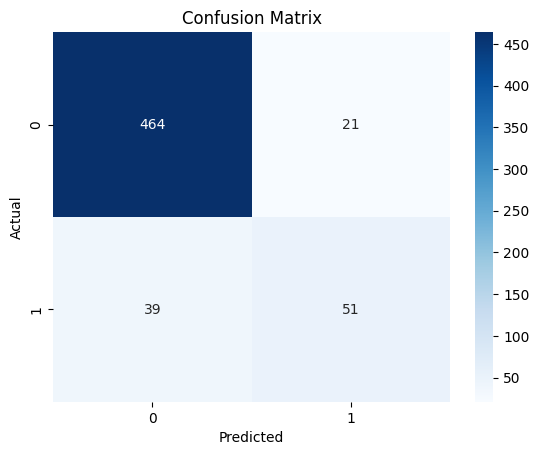

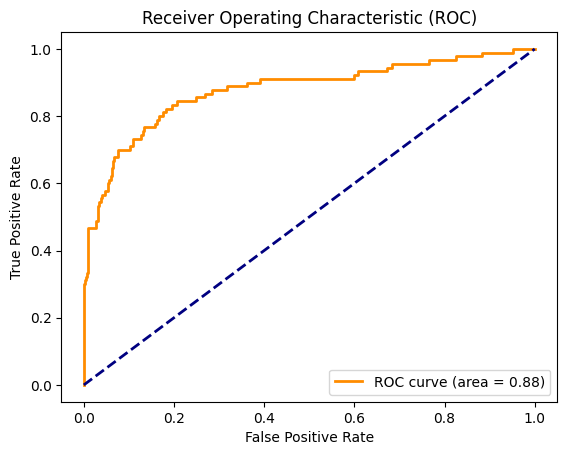

In [86]:
from sklearn.metrics import confusion_matrix,  roc_curve, auc
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, loaded_model_xgb.predict(X_test))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Curva ROC
# Obtener las probabilidades de predicción en lugar de las predicciones directas
y_pred_proba = loaded_model_xgb.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

La curva ROC es una representación gráfica del rendimiento de un modelo de clasificación en diferentes umbrales de clasificación. Tiene dos ejes: el eje X muestra la tasa de falsos positivos y el eje Y muestra la tasa de verdaderos positivos (también conocida como sensibilidad o recall).

-La línea diagonal representa el rendimiento de un clasificador aleatorio.
-La curva ROC del modelo se traza en el espacio ROC, y buscamos que esté lo más cerca posible del punto (0,1), que indica una tasa de verdaderos positivos del 100% y una tasa de falsos positivos del 0%.
-El área bajo la curva ROC (AUC) es una medida cuantitativa del rendimiento del modelo. Un AUC más cercano a 1 indica un mejor rendimiento del modelo, mientras que un AUC de 0.5 indica un rendimiento similar al de un clasificador aleatorio.

En resumen, al interpretar una curva ROC, buscamos un AUC alto, lo que indica un modelo con un buen rendimiento en la clasificación de las instancias.

************

##### Cluster 1

In [78]:
X = dict_cluster_dfs[1].drop(columns='Exited')
y = dict_cluster_dfs[1]['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=24)
X_train_resampled_clust1, y_train_resampled_clust1 = smote.fit_resample(X_train , y_train)

# BaseLine(X_train_resampled_clust1, y_train_resampled_clust1, cv=5, metricas_cross_validate= ['accuracy', 'f1_macro', 'recall_macro', 'precision_macro'])

In [42]:
# clust1_rnd = RandomForestClassifier(bootstrap = False, max_depth = 12, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 4, n_estimators = 300)
# clust1_rnd.fit(X_train_resampled_clust1, y_train_resampled_clust1)
# print(classification_report(y_test, clust1_rnd.predict(X_test) ))

RandomForestClassifier(bootstrap=False, max_depth=12, min_samples_leaf=2,
                       min_samples_split=4, n_estimators=300)

In [44]:
# clust1_xgb = xgb.XGBClassifier(learning_rate = 0.01, max_depth = 8, reg_lambda = 0.01, min_child_weight = 2, n_estimators = 300)
# clust1_xgb.fit(X_train_resampled_clust1, y_train_resampled_clust1)
# print(classification_report(y_test, clust1_xgb.predict(X_test) ))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [79]:
# stacking_clust1 = StackingClassifier(
#     estimators=[ 
#         ('xgb', xgb.XGBClassifier(learning_rate = 0.01, max_depth = 8, reg_lambda = 0.01, min_child_weight = 2, n_estimators = 300)),
#         ('rf', RandomForestClassifier(bootstrap = False, max_depth = 12, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 4, n_estimators = 300)),
#     ],
#     final_estimator=CatBoostClassifier(iterations=500, learning_rate=0.005, l2_leaf_reg=5, depth=8,silent=True),
#     cv=5 
# )

# stacking_clust1.fit(X_train_resampled_clust1, y_train_resampled_clust1)
# print(classification_report(y_test, stacking_clust1.predict(X_test) ))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       657
           1       0.57      0.51      0.54       181

    accuracy                           0.81       838
   macro avg       0.72      0.70      0.71       838
weighted avg       0.80      0.81      0.81       838



In [87]:
# Guardar el modelo en un archivo
# with open('./modelos/modelo_clust1_rnd.pkl', 'wb') as f:
#     pickle.dump(clust1_rnd, f)
    
# # Cargar el modelo desde el archivo
with open('./modelos/modelo_clust1_rnd.pkl', 'rb') as f:
    loaded_model_xgb = pickle.load(f)

print(classification_report(y_test, loaded_model_xgb.predict(X_test) ))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       485
           1       0.50      0.49      0.49        90

    accuracy                           0.84       575
   macro avg       0.70      0.70      0.70       575
weighted avg       0.84      0.84      0.84       575



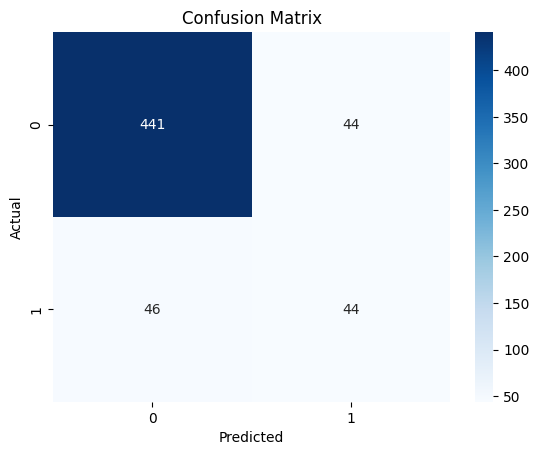

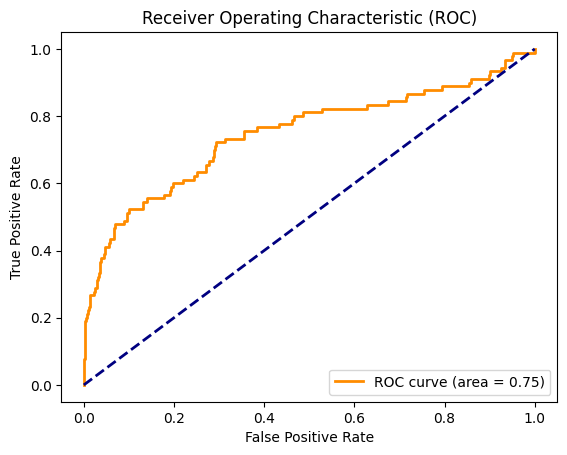

In [89]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, loaded_model_xgb.predict(X_test))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Curva ROC
y_pred_proba = loaded_model_xgb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

****************

##### Cluster 2

In [81]:
X = dict_cluster_dfs[2].drop(columns='Exited')
y = dict_cluster_dfs[2]['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=24)
X_train_resampled_clust2, y_train_resampled_clust2 = smote.fit_resample(X_train , y_train)

# BaseLine(X_train_resampled_clust2, y_train_resampled_clust2, cv=5, metricas_cross_validate= ['accuracy', 'f1_macro', 'recall_macro', 'precision_macro'])

In [48]:
# clust2_xgb = xgb.XGBClassifier(learning_rate = 0.01, max_depth = 8, reg_lambda = 0.01, reg_alpha=0.1, colsample_bytree=0.7, subsample=0.9, min_child_weight = 2, n_estimators = 200)
# clust2_xgb.fit(X_train_resampled_clust2, y_train_resampled_clust2)
# print(classification_report(y_test, clust2_xgb.predict(X_test) ))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       485
           1       0.68      0.61      0.64        90

    accuracy                           0.89       575
   macro avg       0.80      0.78      0.79       575
weighted avg       0.89      0.89      0.89       575



In [49]:
# clus2_cat = CatBoostClassifier(bagging_temperature = 20, depth = 7, iterations = 200, l2_leaf_reg =  7, learning_rate =  0.05, silent=True)
# clus2_cat.fit(X_train_resampled_clust2, y_train_resampled_clust2)
# print(classification_report(y_test, clus2_cat.predict(X_test) ))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       485
           1       0.68      0.62      0.65        90

    accuracy                           0.90       575
   macro avg       0.81      0.78      0.79       575
weighted avg       0.89      0.90      0.89       575



In [82]:
# stacking_clust2 = StackingClassifier(
#     estimators=[ 
#         ('xgb', xgb.XGBClassifier(learning_rate = 0.01, max_depth = 8, reg_lambda = 0.01, reg_alpha=0.1, colsample_bytree=0.7, subsample=0.9, min_child_weight = 2, n_estimators = 200)),
#         ('rf', CatBoostClassifier(iterations=500, learning_rate=0.005, l2_leaf_reg=5, depth=8,silent=True)),
#     ],
#     final_estimator=RandomForestClassifier(bootstrap = False, max_depth = 12, n_estimators = 300),
#     cv=5 
# )

# stacking_clust2.fit(X_train_resampled_clust2, y_train_resampled_clust2)
# print(classification_report(y_test, stacking_clust2.predict(X_test) ))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       485
           1       0.64      0.60      0.62        90

    accuracy                           0.89       575
   macro avg       0.78      0.77      0.78       575
weighted avg       0.88      0.89      0.88       575



In [90]:
# # Guardar el modelo en un archivo
# with open('./modelos/modelo_clus2_cat.pkl', 'wb') as f:
#     pickle.dump(clus2_cat, f)
    
# # # Cargar el modelo desde el archivo
with open('./modelos/modelo_clus2_cat.pkl', 'rb') as f:
    loaded_model_xgb = pickle.load(f)

print(classification_report(y_test, loaded_model_xgb.predict(X_test) ))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       485
           1       0.68      0.62      0.65        90

    accuracy                           0.90       575
   macro avg       0.81      0.78      0.79       575
weighted avg       0.89      0.90      0.89       575



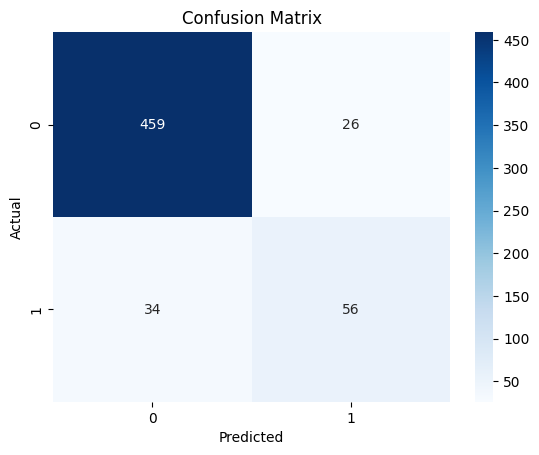

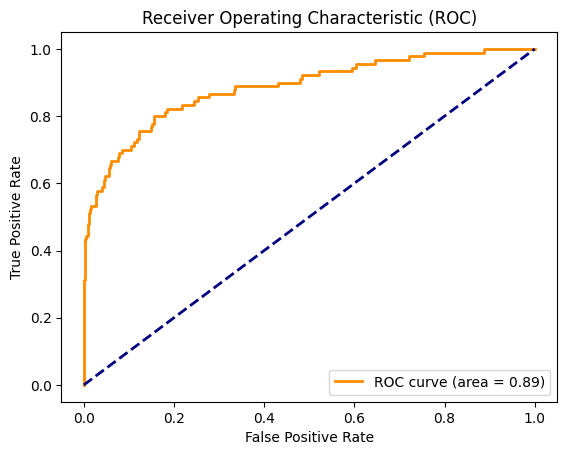

In [91]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test,  loaded_model_xgb.predict(X_test))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Curva ROC
y_pred_proba = loaded_model_xgb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### Modelo 7
**Aplicaremos la cluesterización manual por Geography**

##### df_france

In [51]:
df = pd.read_csv('./data/processed/Churn_Modelling.csv')

df['is_male'] = df['Gender'].replace({'Female': 0, 'Male' : 1})
df.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Gender'], inplace=True)

df_france = df[df['Geography'] == 'France']
df_spain = df[df['Geography'] == 'Spain']
df_germany = df[df['Geography'] == 'Germany']


In [57]:
df_france['CreditCardOwnerTenure'] = df_france.HasCrCard * df_france.Age
df_france['Saldo_Salario_Ratio'] = df_france['Balance'] / df_france['EstimatedSalary']

numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary','CreditCardOwnerTenure', 'Saldo_Salario_Ratio']
variables_sin_modificacion = ['HasCrCard', 'IsActiveMember', 'Exited', 'is_male']

# Definir transformadores para características numéricas y categóricas
numeric_transformer = StandardScaler()

# Crear un ColumnTransformer para aplicar transformaciones a diferentes columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ]
)

# Crear el pipeline con el preprocesador
pipeline = make_pipeline(preprocessor)
# Aplicar el preprocesador a los datos
X_processed = pipeline.fit_transform(df_france)

# Crear DataFrame con los datos procesados y los nombres de las columnas
processed_df_france = pd.DataFrame(X_processed, columns=numeric_features)
concatenated_series_france  = pd.concat((processed_df_france, df_france[[ 'HasCrCard', 'IsActiveMember', 'Exited', 'is_male']].reset_index(drop=True)), axis=1)

X = concatenated_series_france.drop(columns='Exited')
y = concatenated_series_france['Exited']

# # Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# # Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=24)
X_train_resampled_france, y_train_resampled_france = smote.fit_resample(X_train , y_train)

# BaseLine(X_train_resampled_france, y_train_resampled_france, cv=5, metricas_cross_validate= ['accuracy', 'f1_macro', 'recall_macro', 'precision_macro']) 

In [53]:
# rnd = RandomForestClassifier(bootstrap=False, max_depth=8, min_samples_leaf=2, min_samples_split=4, n_estimators=300, criterion='entropy')
# rnd.fit(X_train_resampled_france, y_train_resampled_france)
# print(classification_report(y_test, rnd.predict(X_test) ))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       843
           1       0.50      0.62      0.55       160

    accuracy                           0.84      1003
   macro avg       0.71      0.75      0.73      1003
weighted avg       0.86      0.84      0.85      1003



In [55]:
# cat = CatBoostClassifier(iterations=300, learning_rate=0.005, l2_leaf_reg=3, depth=8, silent=True)
# cat.fit(X_train_resampled_france, y_train_resampled_france)
# print(classification_report(y_test, cat.predict(X_test) ))

              precision    recall  f1-score   support

           0       0.93      0.86      0.89       843
           1       0.46      0.65      0.54       160

    accuracy                           0.82      1003
   macro avg       0.69      0.75      0.71      1003
weighted avg       0.85      0.82      0.83      1003



In [58]:
# stacking_france = StackingClassifier(
#     estimators=[
#         ('xgb', xgb.XGBClassifier(learning_rate=0.01, max_depth=8, min_child_weight=2, n_estimators=300)),
#         ('rf', RandomForestClassifier(bootstrap=False, max_depth=8, min_samples_leaf=2, min_samples_split=4, n_estimators=300, criterion='entropy')),
#     ],
#     final_estimator=CatBoostClassifier(iterations=300, learning_rate=0.005, l2_leaf_reg=3, depth=8, silent=True), 
#     cv=5 
# )

# stacking_france.fit(X_train_resampled_france, y_train_resampled_france)
# print(classification_report(y_test, stacking_france.predict(X_test) ))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90       843
           1       0.50      0.63      0.56       160

    accuracy                           0.84      1003
   macro avg       0.71      0.76      0.73      1003
weighted avg       0.86      0.84      0.85      1003



In [60]:
# # Guardar el modelo en un archivo
# with open('./modelos/modelo_stacking_france.pkl', 'wb') as f:
#     pickle.dump(stacking_france, f)
    
# # Cargar el modelo desde el archivo
with open('./modelos/modelo_stacking_france.pkl', 'rb') as f:
    loaded_model_xgb = pickle.load(f)

print(classification_report(y_test, loaded_model_xgb.predict(X_test) ))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90       843
           1       0.50      0.63      0.56       160

    accuracy                           0.84      1003
   macro avg       0.71      0.76      0.73      1003
weighted avg       0.86      0.84      0.85      1003



**********

##### df_spain

In [61]:
numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
variables_sin_modificacion = ['HasCrCard', 'IsActiveMember', 'Exited', 'is_male']

# Definir transformadores para características numéricas y categóricas
numeric_transformer = StandardScaler()

# Crear un ColumnTransformer para aplicar transformaciones a diferentes columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ]
)

# Crear el pipeline con el preprocesador
pipeline = make_pipeline(preprocessor)
# Aplicar el preprocesador a los datos
X_processed = pipeline.fit_transform(df_spain)

# # Crear DataFrame con los datos procesados y los nombres de las columnas
processed_df_spain = pd.DataFrame(X_processed, columns=numeric_features)
concatenated_series_spain  = pd.concat((processed_df_spain, df_spain[['HasCrCard', 'IsActiveMember', 'Exited', 'is_male']].reset_index(drop=True)), axis=1)

X = concatenated_series_spain.drop(columns='Exited')
y = concatenated_series_spain['Exited']

# # # Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

# # # Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=24)
X_train_resampled_spain, y_train_resampled_spain = smote.fit_resample(X_train , y_train)

# BaseLine(X_train_resampled_spain, y_train_resampled_spain, cv=5, metricas_cross_validate= ['accuracy', 'f1_macro', 'recall_macro', 'precision_macro'])

In [62]:
# stacking_clf_test = StackingClassifier(
#     estimators=[ 
#         ('xgb', xgb.XGBClassifier(colsample_bytree = 0.9, learning_rate = 0.005, max_depth = 8, n_estimators = 200, subsample = 0.9)),
#         ('rf', RandomForestClassifier(bootstrap =  False, max_depth =  30, max_features =  'sqrt', min_samples_leaf =  1, min_samples_split =  2, n_estimators =  100)),
#     ],
#     final_estimator=CatBoostClassifier(iterations=500, learning_rate=0.005,  depth=8, l2_leaf_reg= 2, silent=True),
#     cv=5 
# )

# stacking_clf_test.fit(X_train_resampled_spain, y_train_resampled_spain)
# print(classification_report(y_test, stacking_clf_test.predict(X_test) ))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       417
           1       0.53      0.39      0.45        79

    accuracy                           0.85       496
   macro avg       0.71      0.66      0.68       496
weighted avg       0.83      0.85      0.84       496



In [64]:
# stacking_spain = StackingClassifier(
#     estimators=[ 
#         ('xgb', xgb.XGBClassifier(colsample_bytree = 0.9, learning_rate = 0.05, max_depth = 8, n_estimators = 200, subsample = 0.9)),
#         ('rf', RandomForestClassifier(bootstrap =  False, max_depth =  30, max_features =  'sqrt', min_samples_leaf =  1, min_samples_split =  2, n_estimators =  100)),
#     ],
#     final_estimator=CatBoostClassifier(iterations=500, learning_rate=0.005,  depth=13, silent=True),
#     cv=5 
# )

# stacking_spain.fit(X_train_resampled_spain, y_train_resampled_spain)
# print(classification_report(y_test, stacking_spain.predict(X_test) ))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93       417
           1       0.64      0.46      0.53        79

    accuracy                           0.87       496
   macro avg       0.77      0.70      0.73       496
weighted avg       0.86      0.87      0.86       496



In [66]:
# # # Guardar el modelo en un archivo
# with open('./modelos/modelo_stacking_spain.pkl', 'wb') as f:
#     pickle.dump(stacking_spain, f)
    
# # Cargar el modelo desde el archivo
with open('./modelos/modelo_stacking_spain.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

print(classification_report(y_test, loaded_model.predict(X_test) ))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93       417
           1       0.64      0.46      0.53        79

    accuracy                           0.87       496
   macro avg       0.77      0.70      0.73       496
weighted avg       0.86      0.87      0.86       496



*******************

##### df_german

In [67]:
X = df_germany.drop(columns='Exited')
y = df_germany['Exited']

numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
variables_sin_modificacion =  df_germany[[ 'HasCrCard', 'IsActiveMember', 'is_male']]

# Definir transformadores para características numéricas y categóricas
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

# Crear un ColumnTransformer para aplicar transformaciones a diferentes columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ]
)
# Crear el pipeline con el preprocesador
pipeline = make_pipeline(preprocessor)
# Aplicar el preprocesador a los datos
X_processed = pipeline.fit_transform(X)

# Crear DataFrame con los datos procesados y los nombres de las columnas
processed_df = pd.DataFrame(X_processed, columns=numeric_features)
concatenated_series_germany  = pd.concat([processed_df, variables_sin_modificacion.reset_index(drop=True) ], axis=1) #

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(concatenated_series_germany, y, test_size=0.2, random_state=24)

# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=24)
X_train_resampled_germany, y_train_resampled_germany = smote.fit_resample(X_train, y_train)

# BaseLine(X_train_resampled_germany, y_train_resampled_germany, cv=5, metricas_cross_validate= ['accuracy', 'f1_macro', 'recall_macro', 'precision_macro'])

In [68]:
# grid_2 = {
#     'n_estimators': [100, 150],
#     'max_depth': [10, 15],
#     'min_samples_split': [8, 10],
#     'min_samples_leaf': [3, 4],
#     'bootstrap': [True]
# }

# forest_german = RandomForestClassifier()

# grid_search_german_forest = GridSearchCV(forest_german,
#                            grid_2,
#                            cv=5,
#                            scoring='precision_macro',
#                            n_jobs=-1
#                           )

# grid_search_german_forest.fit(X_train_resampled_germany, y_train_resampled_germany)

# forest_german = RandomForestClassifier(bootstrap = True, max_depth = 15, min_samples_leaf = 3, min_samples_split = 10, n_estimators = 100)
# forest_german.fit(X_train_resampled_germany, y_train_resampled_germany)

# print(classification_report(y_test, forest_german.predict(X_test) ))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85       345
           1       0.66      0.69      0.68       157

    accuracy                           0.79       502
   macro avg       0.76      0.76      0.76       502
weighted avg       0.80      0.79      0.79       502



In [71]:
# grid_2 = {
#     'n_estimators': [100, 200],
#     'learning_rate': [0.01, 0.05],
#     'max_depth': [6, 8],
#     'subsample': [0.7, 0.9],
#     'colsample_bytree': [0.7, 0.9]
# }

# xgb_german = xgb.XGBClassifier()

# grid_search_german_xgb = GridSearchCV(xgb_german,
#                            grid_2,
#                            cv=5,
#                            scoring='precision_macro',
#                            n_jobs=-1
#                           )

# grid_search_german_xgb.fit(X_train_resampled_germany, y_train_resampled_germany)

# xgb_german = xgb.XGBClassifier(colsample_bytree =  0.9, learning_rate =  0.05, max_depth =  8, n_estimators =  200, subsample =  0.7)
# xgb_german.fit(X_train_resampled_germany, y_train_resampled_germany)

# print(classification_report(y_test, xgb_german.predict(X_test) ))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84       345
           1       0.65      0.66      0.66       157

    accuracy                           0.78       502
   macro avg       0.75      0.75      0.75       502
weighted avg       0.79      0.78      0.79       502



In [70]:
# stacking_german = StackingClassifier(
#     estimators=[ 
#         ('xgb', xgb.XGBClassifier(colsample_bytree =  0.9, learning_rate =  0.05, max_depth =  8, n_estimators =  200, subsample =  0.7)),
#         ('rf', RandomForestClassifier(bootstrap = True, max_depth = 15, min_samples_leaf = 3, min_samples_split = 10, n_estimators = 100)),
#     ],
#     final_estimator=CatBoostClassifier(iterations=300, learning_rate=0.001, silent=True),
#     cv=5 
# )

# stacking_german.fit(X_train_resampled_germany, y_train_resampled_germany)
# print(classification_report(y_test, stacking_german.predict(X_test) ))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85       345
           1       0.68      0.66      0.67       157

    accuracy                           0.80       502
   macro avg       0.76      0.76      0.76       502
weighted avg       0.80      0.80      0.80       502



In [72]:
# # # Guardar el modelo en un archivo
# with open('./modelos/modelo_stacking_german.pkl', 'wb') as f:
#     pickle.dump(stacking_german, f)
    
# # Cargar el modelo desde el archivo
with open('./modelos/modelo_stacking_german.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

print(classification_report(y_test, loaded_model.predict(X_test) ))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85       345
           1       0.68      0.66      0.67       157

    accuracy                           0.80       502
   macro avg       0.76      0.76      0.76       502
weighted avg       0.80      0.80      0.80       502

